In [85]:
import matplotlib.pyplot as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.linalg import block_diag
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# https://github.com/emoen/Machine-Learning-for-Asset-Managers/blob/577f951c8aeb3b478118c3aa30f341be9f8ee09d/Machine_Learning_for_Asset_Managers/ch2_monte_carlo_experiment.py#L15
# https://github.com/emoen/Machine-Learning-for-Asset-Managers/blob/577f951c8aeb3b478118c3aa30f341be9f8ee09d/Machine_Learning_for_Asset_Managers/ch7_portfolio_construction.py#L55
# https://github.com/emoen/Machine-Learning-for-Asset-Managers/blob/577f951c8aeb3b478118c3aa30f341be9f8ee09d/Machine_Learning_for_Asset_Managers/ch7_portfolio_construction.py#L87

In [81]:
def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones( (bSize, bSize))*bCorr
    block[range(bSize), range(bSize)] = 1 #diagonal is 1
    corr = block_diag(*([block]*nBlocks))
    return corr

def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    std0 = np.random.uniform(.05, .2, corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1,1)
    return mu0, cov0

def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

def deNoiseCov(cov0, q, bWidth):
    corr0 = cov2corr(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    nFacts0 = eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0) #denoising by constant residual eigenvalue method
    cov1 = corr2cov(corr1, np.diag(cov0)**.5)
    return cov1

def getPCA(matrix):
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eig(matrix) #complex Hermitian (conjugate symmetric) or a real symmetric matrix.
    indices = eVal.argsort()[::-1] #arguments for sorting eval desc
    eVal,eVec = eVal[indices],eVec[:,indices]
    eVal = np.diagflat(eVal) # identity matrix with eigenvalues as diagonal
    return eVal,eVec

def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
#     print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var


def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
#     print("sse:"+str(sse))
    return sse

def mpPDF(var, q, pts):
    eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2 # calc lambda_minus, lambda_plus
    eVal = np.linspace(eMin, eMax, pts) #Return evenly spaced numbers over a specified interval. eVal='lambda'
    #Note: 1.0/2*2 = 1.0 not 0.25=1.0/(2*2)
    pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 #np.allclose(np.flip((eMax-eVal)), (eVal-eMin))==True
    pdf = pd.Series(pdf, index=eVal)
    return pdf

def fitKDE(obs, bWidth=.15, kernel='gaussian', x=None):
    #Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    #print(len(obs.shape) == 1)
    if len(obs.shape) == 1: obs = obs.reshape(-1,1)
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    #print(x is None)
    if x is None: x = np.unique(obs).reshape(-1,1)
    #print(len(x.shape))
    if len(x.shape) == 1: x = x.reshape(-1,1)
    logProb = kde.score_samples(x) # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts) #all but 0..i values equals (1/N-i)sum(eVal_[i..N]))
    eVal_ = np.diag(eVal_) #square matrix with eigenvalues as diagonal: eVal_.I
    corr1 = (eVec @ eVal_).dot(eVec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    corr1 = cov2corr(corr1) # Rescaling the correlation matrix to have 1s on the main diagonal
    return corr1

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    dist_matrix = ((1-corr0.fillna(0))/2.)**.5
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
#     print("maxNumClusters"+str(maxNumClusters))
    for init in range(0, n_init):
    #The [outer] loop repeats the first loop multiple times, thereby obtaining different initializations. Ref: de Prado and Lewis (2018)
    #DETECTION OF FALSE INVESTMENT STRATEGIES USING UNSUPERVISED LEARNING METHODS
        for num_clusters in range(2, maxNumClusters+1):
            #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10) #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug==True:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                    print("********")
    
    newIdx = np.argsort(kmeans.labels_)
    #print(newIdx)

    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)
    
    return corr1, clstrs, silh_coef_optimal

<AxesSubplot:>

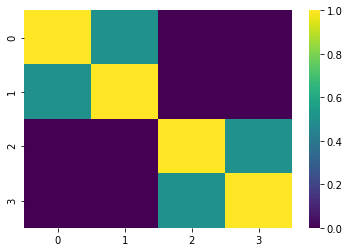

In [16]:
# code snippet 7.1 - Composition of block-diagonal correlation matric
corr0 = formBlockMatrix(2, 2, .5)
eVal, eVec = np.linalg.eigh(corr0)
print = max(eVal)/min(eVal)
sns.heatmap(corr0, cmap='viridis')

In [73]:
# code snippet 7.2 - block-diagonal correlation matrix with a dominant block
corr0 = block_diag(formBlockMatrix(1,2, .5))
corr1 = formBlockMatrix(1,2, .0)
corr0 = block_diag(corr0, corr1)
eVal, eVec = np.linalg.eigh(corr0)
max(eVal) / min(eVal)

3.0

In [86]:
# code snippet 7.3 - NCO method. Step 1. Correlation matrix clustering
# nBlocks, bSize, bCorr = 2, 2, .5
# q = 10.0
# np.random.seed(0)
# mu0, cov0 = mc.formTrueMatrix(nBlocks, bSize, bCorr)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)
cols = cov0.columns
cov1 = deNoiseCov(cov0, q, bWidth=.01) #denoise cov
cov1 = pd.DataFrame(cov1, index=cols, columns=cols)
corr1 = cov2corr(cov1)
corr1, clstrs, silh = clusterKMeansBase(pd.DataFrame(corr0))

In [95]:
def minVarPort(cov):
    return optPort(cov, mu = None)

def optPort(cov, mu = None):
    inv = np.linalg.inv(cov) #The precision matrix: contains information about the partial correlation between variables,
    #  the covariance between pairs i and j, conditioned on all other variables (https://www.mn.uio.no/math/english/research/projects/focustat/publications_2/shatthik_barua_master2017.pdf)
    ones = np.ones(shape = (inv.shape[0], 1)) # column vector 1's
    if mu is None: 
        mu = ones
    w = inv @ mu
    w /= ones.T @  w # def: w = w / sum(w) ~ w is column vector
    
    return w

In [97]:
# code snippet 7.4 - intracluster optimal allocations
wIntra = pd.DataFrame(0, index=cov0.index, columns=clstrs.keys())
for i in clstrs:
    wIntra.loc[clstrs[i], i] = minVarPort(cov1.loc[clstrs[i], clstrs[i]]).flatten()

cov2 = wIntra.T.dot( cov1 @ wIntra) #reduced covariance matrix

In [98]:
# code snippet 7.5 - intercluster optimal allocations
# step 3. compute optimal intercluster allocations, usint the reduced covariance matrix
# which is close to a diagonal matrix, so optimization problem is close to ideal case \ro =0
wInter = pd.Series(minVarPort(cov2).flatten(), index=cov2.index)
wAll0 = wIntra.mul(wInter, axis=1).sum(axis=1).sort_index()

In [ ]:
# 7.6
def optPort_nco(cov, mu=None, maxNumClusters=None):
    cov = pd.DataFrame(cov)
    if mu is not None:
        mu = pd.Series(mu[:,0])
    
    corr1 = cov2corr(cov)
    
    # Optimal partition of clusters (step 1)
    corr1, clstrs, _ = clusterKMeansBase(corr1, maxNumClusters, n_init=10)
    #wIntra = pd.DataFrame(0, index=cov.index, columns=clstrs.keys())
    w_intra_clusters = pd.DataFrame(0, index=cov.index, columns=clstrs.keys())
    for i in clstrs:
        cov_cluster = cov.loc[clstrs[i], clstrs[i]].values
        if mu is None:
            mu_cluster = None
        else: 
            mu_cluster = mu.loc[clstrs[i]].values.reshape(-1,1)
        
        #Long/Short
        #w_intra_clusters.loc[clstrs[i],i] = mc.optPort(cov_cluster, mu_cluster).flatten()
        
        # Long only: Estimating the Convex Optimization Solution in a cluster (step 2)
        w_intra_clusters.loc[clstrs[i], i] = allocate_cvo(cov_cluster, mu_cluster).flatten()        
    
    cov_inter_cluster = w_intra_clusters.T.dot( cov @ w_intra_clusters) #reduce covariance matrix
    mu_inter_cluster = (None if mu is None else w_intra_clusters.T.dot(mu))
    
    #Long/Short
    #w_inter_clusters = pd.Series(mc.optPort(cov_inter_cluster, mu_inter_cluster).flatten(), index=cov_inter_cluster.index)
    # Long only: Optimal allocations across the reduced covariance matrix (step 3)
    w_inter_clusters = pd.Series(allocate_cvo(cov_inter_cluster, mu_inter_cluster).flatten(), index=cov_inter_cluster.index)    
    
    # Final allocations - dot-product of the intra-cluster and inter-cluster allocations (step 4)
    nco = w_intra_clusters.mul(w_inter_clusters, axis=1).sum(axis=1).values.reshape(-1,1)
    return nco

def allocate_cvo(cov, mu_vec=None):
    """
    Estimates the Convex Optimization Solution (CVO).
    Uses the covariance matrix and the mu - optimal solution.
    If mu is the vector of expected values from variables, the result will be
    a vector of weights with maximum Sharpe ratio.
    If mu is a vector of ones, the result will be a vector of weights with
    minimum variance.
    :param cov: (np.array) Covariance matrix of the variables.
    :param mu_vec: (np.array) Expected value of draws from the variables for maximum Sharpe ratio.
                          None if outputting the minimum variance portfolio.
    :return: (np.array) Weights for optimal allocation.
    """
    
    # Calculating the inverse covariance matrix
    inv_cov = np.linalg.inv(cov)
    
    # Generating a vector of size of the inverted covariance matrix
    ones = np.ones(shape=(inv_cov.shape[0], 1))
    
    if mu_vec is None:  # To output the minimum variance portfolio
        mu_vec = ones
    
    # Calculating the analytical solution using CVO - weights
    w_cvo = np.dot(inv_cov, mu_vec)
    w_cvo /= np.dot(mu_vec.T, w_cvo)
    
    return w_cvo    

In [101]:
# code snippet 7.7 - data-generating process
nBlocks, bSize, bCorr = 10, 50, .5
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

In [104]:
def simCovMu(mu0, cov0, nObs, shrink=False):
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size = nObs)
    #print(x.shape)
    mu1 = x.mean(axis = 0).reshape(-1,1) #calc mean of columns of rand matrix
    #print(mu1.shape)
    if shrink: cov1 = LedoitWolf().fit(x).covariance_
    else: cov1 = np.cov(x, rowvar=0)
    return mu1, cov1

In [ ]:
# code snippet 7.8 - drawing an empirical vector of means and covariance matrix
nObs, nSims, shrink, minVarPortf = 1000, 1000, False, True
np.random.seed(0)
w1 = pd.DataFrame(0, index=range(0, nSims), columns=range(0, nBlocks*bSize))	
w1_d = pd.DataFrame(0, index=range(0, nSims), columns=range(0, nBlocks*bSize))
for i in range(0, nSims):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)
    if minVarPortf:
        mu1 = None
    w1.loc[i] = optPort(cov1, mu1).flatten() #markowitc
    w1_d.loc[i] = optPort_nco(cov1, mu1, int(cov1.shape[0]/2)).flatten() #nco

In [ ]:
# code snippet 7.9 - Estimation of allocation errors
w0 = mc.optPort(cov0, None if minVarPortf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis=0) #true allocation
rmsd = np.mean((w1-w0).values.flatten()**2)**.5 #RMSE
rmsd_d = np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE